## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) $N \% 5$
2) $N^2 \% 5 + 5$
где $N$ - номер в списке


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.float_format', lambda x: f"{x:.4f}")

DATA_PATH = '/Users/victoriasamsonova/bsu/oiad/oiad-11-2025/datasets/students_simple.csv'
N = 24

df = pd.read_csv(DATA_PATH)
idx1 = N % 5
idx2 = (N * N) % 5 + 5

column_name_1 = df.columns[idx1]
column_name_2 = df.columns[idx2]

pair_df = df[[column_name_1, column_name_2]].dropna()
pages = pair_df[column_name_1].astype(float).to_numpy()
bmi = pair_df[column_name_2].astype(float).to_numpy()

n = len(pages)
print(f"Выбраны столбцы: {column_name_1} и {column_name_2}. Число пар после очистки: n={n}")

Выбраны столбцы: pages и bmi. Число пар после очистки: n=20



## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [23]:
# Корреляция Фехнера
def fechner_correlation(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.sign(x - mx)
    sy = np.sign(y - my)
    mask = (sx != 0) & (sy != 0)
    if not np.any(mask):
        return np.nan
    sx = sx[mask]
    sy = sy[mask]
    same = np.sum(sx == sy)
    diff = np.sum(sx != sy)
    return (same - diff) / (same + diff)

# Корреляция Пирсона
def pearson_correlation(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    xm = x - x.mean()
    ym = y - y.mean()
    denom = np.sqrt((xm ** 2).sum() * (ym ** 2).sum())
    if denom == 0:
        return np.nan
    return (xm * ym).sum() / denom

# Корреляция Спирмена 
from scipy.stats import rankdata

def spearman_correlation(x, y):
    rx = rankdata(x, method='average')
    ry = rankdata(y, method='average')
    return pearson_correlation(rx, ry)

# Корреляция Кендалла tau-b (корректна при связях)
def kendall_correlation(x, y):
    tau, _ = stats.kendalltau(x, y, variant='b')
    return tau

# Доверительный интервал Пирсона через преобразование Фишера z и p-value через t-статистику
def pearson_ci_p(x, y, alpha=0.05):
    r = pearson_correlation(x, y)
    n = len(x)
    if n < 4 or np.isnan(r):
        return r, (np.nan, np.nan), np.nan
    # Fisher z
    z = 0.5 * np.log((1 + r) / (1 - r))
    se_z = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    z_lo = z - z_crit * se_z
    z_hi = z + z_crit * se_z
    # Обратное преобразование
    lo = (np.exp(2 * z_lo) - 1) / (np.exp(2 * z_lo) + 1)
    hi = (np.exp(2 * z_hi) - 1) / (np.exp(2 * z_hi) + 1)
    # t-статистика для проверки H0: r=0
    t_stat = r * np.sqrt((n - 2) / (1 - r ** 2))
    p_value = 2 * stats.t.sf(np.abs(t_stat), df=n - 2)
    return r, (lo, hi), p_value

fechner_corr = fechner_correlation(pages, bmi)
pearson_corr, (ci_lower, ci_upper), pearson_pval = pearson_ci_p(pages, bmi)
spearman_corr = spearman_correlation(pages, bmi)
kendall_corr = kendall_correlation(pages, bmi)

# из библиотек
pearson_lib = stats.pearsonr(pages, bmi)
spearman_lib = stats.spearmanr(pages, bmi)
kendall_lib = stats.kendalltau(pages, bmi, variant='b')

print(f"Корреляция Фехнера: {fechner_corr:.4f}")
print(f"Корреляция Пирсона (функция): {pearson_corr:.4f}, p-value: {pearson_pval:.4f}, CI95%: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Корреляция Пирсона (scipy): {pearson_lib.statistic:.4f}, p-value: {pearson_lib.pvalue:.4f}")
print(f"Корреляция Спирмена (функция): {spearman_corr:.4f}")
print(f"Корреляция Спирмена (scipy): {spearman_lib.statistic:.4f}")
print(f"Корреляция Кендалла (функция): {kendall_corr:.4f}")
print(f"Корреляция Кендалла (scipy): {kendall_lib.statistic:.4f}")

Корреляция Фехнера: -0.4000
Корреляция Пирсона (функция): -0.1795, p-value: 0.4489, CI95%: [-0.5762, 0.2857]
Корреляция Пирсона (scipy): -0.1795, p-value: 0.4489
Корреляция Спирмена (функция): -0.3239
Корреляция Спирмена (scipy): -0.3239
Корреляция Кендалла (функция): -0.2442
Корреляция Кендалла (scipy): -0.2442


Доверительный интервал Пирсона включает 0, поэтому статистически значимой линейной связи при α=0.05 нет.


## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

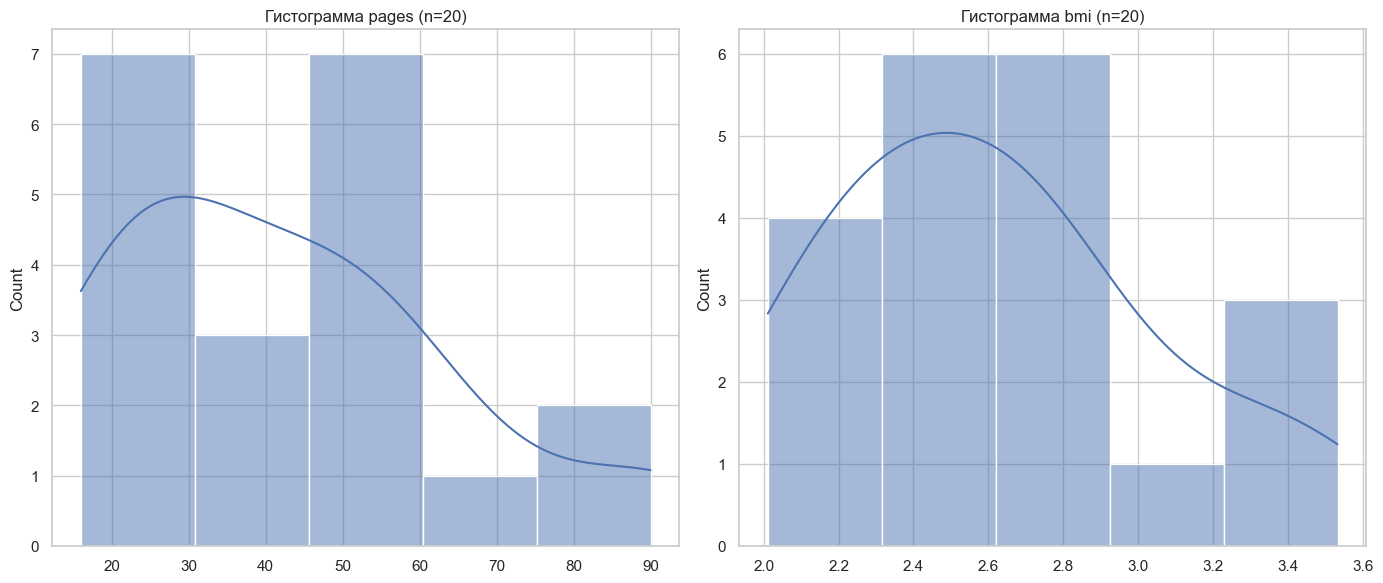

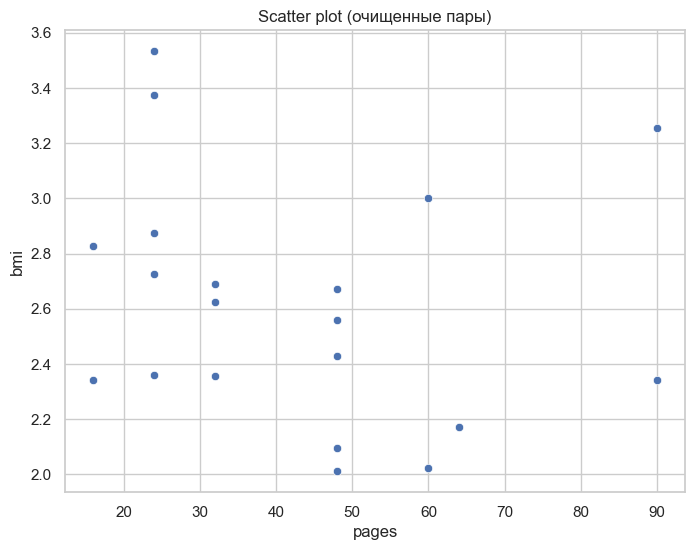

In [24]:
sns.set(style='whitegrid')
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(pages, kde=True, bins=5)
plt.title(f'Гистограмма {column_name_1} (n={len(pages)})')

plt.subplot(1,2,2)
sns.histplot(bmi, kde=True, bins=5)
plt.title(f'Гистограмма {column_name_2} (n={len(bmi)})')
plt.tight_layout()
plt.show()

# Scatter plot на очищенных и выравненных данных
plt.figure(figsize=(8,6))
sns.scatterplot(x=pages, y=bmi)
plt.xlabel(column_name_1)
plt.ylabel(column_name_2)
plt.title('Scatter plot (очищенные пары)')
plt.show()

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

Уравнение линейной регрессии:
y = -0.0035606872223674433x + 2.7650352756728536


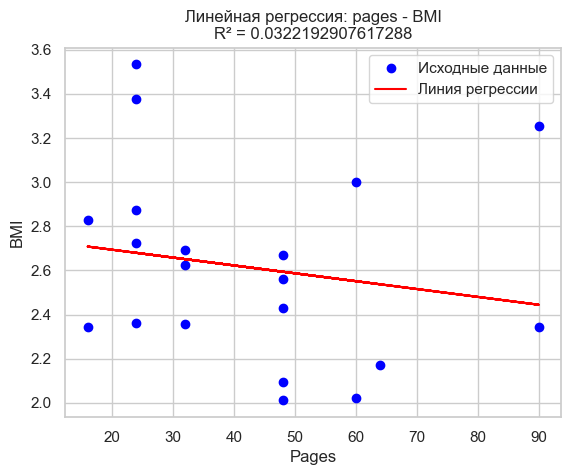

F-статистика = 0.5993
Коэффициент детерминации R² = 0.0322192907617288


In [34]:
sum_pages = sum(pages)
sum_bmi = sum(bmi)
sum_x2 = sum([xi**2 for xi in pages])
sum_xy = sum([pages[i] * bmi[i] for i in range(n)])

w1 = (n * sum_xy - sum_pages * sum_bmi) / (n * sum_x2 - sum_pages**2)
w0 = (sum_bmi - w1 * sum_pages) / n

print("Уравнение линейной регрессии:")
print(f"y = {w1}x + {w0}")

y_pred = [w1 * x + w0 for x in pages]

y_mean = sum(bmi) / n
ss_res = sum((bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((bmi[i] - y_mean)**2 for i in range(n))
r2_linear = 1 - ss_res / ss_tot

linear_params = {'w1': w1, 'w0': w0, 'r2': r2_linear}

plt.scatter(pages, bmi, color='blue', label='Исходные данные')
plt.plot(pages, y_pred, color='red', label='Линия регрессии')

plt.title(f'Линейная регрессия: pages - BMI\nR² = {r2_linear}')
plt.xlabel('Pages')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()


n = len(pages)
k = 2

F_stat_linear = (r2_linear / (1 - r2_linear)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_linear:.4f}")
print(f"Коэффициент детерминации R² = {r2_linear}")

linear_params['F_stat'] = F_stat_linear

Уравнение квадратичной регрессии:
y = 0.0003268599957357457x² + -0.03712896109851586x + 3.4517641124936898
Коэффициент детерминации R² = 0.18297853494685445


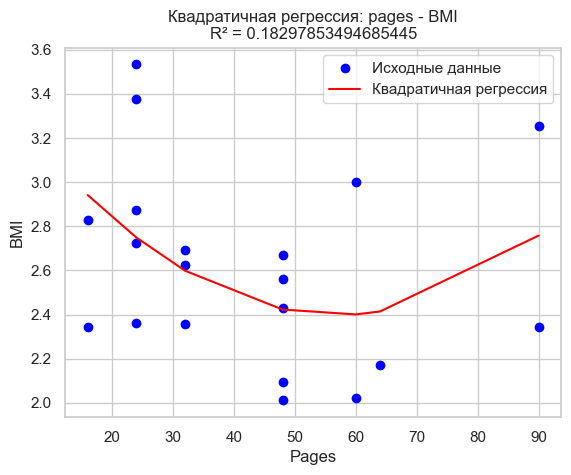

F-статистика = 1.9036
Коэффициент детерминации R² = 0.18297853494685445


In [29]:
sum_x = sum(pages)
sum_x2 = sum(x**2 for x in pages)
sum_x3 = sum(x**3 for x in pages)
sum_x4 = sum(x**4 for x in pages)
sum_y = sum(bmi)
sum_xy = sum(pages[i] * bmi[i] for i in range(n))
sum_x2y = sum((pages[i]**2) * bmi[i] for i in range(n))

A = [
    [sum_x4, sum_x3, sum_x2],
    [sum_x3, sum_x2, sum_x],
    [sum_x2, sum_x, n]
]
B = [sum_x2y, sum_xy, sum_y]

w2, w1, w0 = np.linalg.solve(A, B)

print("Уравнение квадратичной регрессии:")
print(f"y = {w2}x² + {w1}x + {w0}")

y_pred = [w2 * x**2 + w1 * x + w0 for x in pages]

y_mean = sum(bmi) / n
ss_res = sum((bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((bmi[i] - y_mean)**2 for i in range(n))
r2_quadratic = 1 - ss_res / ss_tot

quadratic_params = {'w2': w2, 'w1': w1, 'w0': w0, 'r2': r2_quadratic}

print(f"Коэффициент детерминации R² = {r2_quadratic}")

x_sorted = sorted(pages)
y_fit = [w2 * x**2 + w1 * x + w0 for x in x_sorted]

plt.scatter(pages, bmi, color='blue', label='Исходные данные')
plt.plot(x_sorted, y_fit, color='red', label='Квадратичная регрессия')
plt.title(f'Квадратичная регрессия: pages - BMI\nR² = {r2_quadratic}')
plt.xlabel('Pages')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()


k = 3 
F_stat_quadratic = (r2_quadratic / (1 - r2_quadratic)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_quadratic:.4f}")
print(f"Коэффициент детерминации R² = {r2_quadratic}")


quadratic_params['F_stat'] = F_stat_quadratic

Уравнение гиперболической регрессии:
y = 7.340668504618359/x + 2.3922378497306798
Коэффициент детерминации R² = 0.06699175399187818


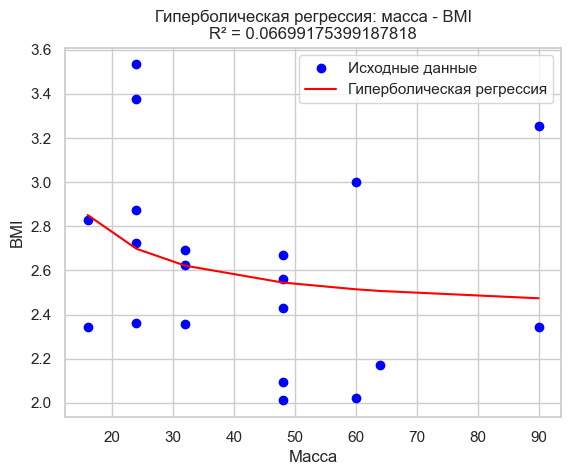

F-статистика = 1.2924
Коэффициент детерминации R² = 0.06699175399187818


In [ ]:
z = [1/x for x in pages]

sum_z = sum(z)
sum_y = sum(bmi)
sum_z2 = sum(zi**2 for zi in z)
sum_zy = sum(z[i] * bmi[i] for i in range(n))

w1 = (n * sum_zy - sum_z * sum_y) / (n * sum_z2 - sum_z**2)
w0 = (sum_y - w1 * sum_z) / n

print("Уравнение гиперболической регрессии:")
print(f"y = {w1}/x + {w0}")

y_pred = [w1 / x + w0 for x in pages]

y_mean = sum(bmi) / n
ss_res = sum((bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((bmi[i] - y_mean)**2 for i in range(n))
r2_hyperbolic = 1 - ss_res / ss_tot

hyperbolic_params = {'w1': w1, 'w0': w0, 'r2': r2_hyperbolic}

print(f"Коэффициент детерминации R² = {r2_hyperbolic}")

x_sorted = sorted(pages)
y_fit = [w1 / x + w0 for x in x_sorted]

plt.scatter(pages, bmi, color='blue', label='Исходные данные')
plt.plot(x_sorted, y_fit, color='red', label='Гиперболическая регрессия')

plt.title(f'Гиперболическая регрессия: масса - BMI\nR² = {r2_hyperbolic}')
plt.xlabel('Масса')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()

k = 2
F_stat_hyperbolic = (r2_hyperbolic / (1 - r2_hyperbolic)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_hyperbolic:.4f}")
print(f"Коэффициент детерминации R² = {r2_hyperbolic}")
hyperbolic_params['F_stat'] = F_stat_hyperbolic

Уравнение показательной регрессии:
y = 2.743893539977673 * (0.9985554453979646)^x
R² = 0.028906086673075482
R² (для логарифмической модели) = 0.037836903631726315


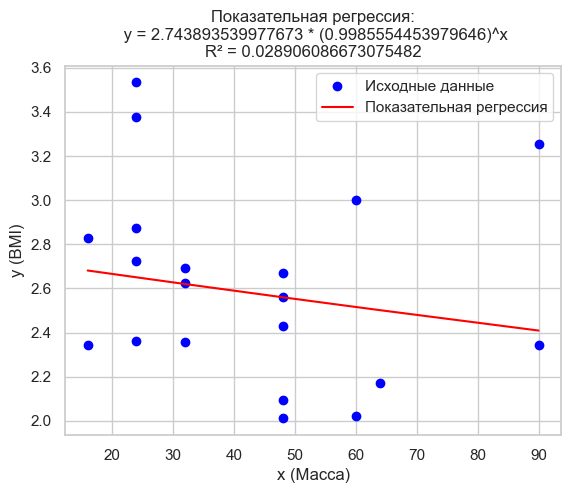

F-статистика = 0.5358
Коэффициент детерминации R² = 0.028906086673075482


In [32]:
import math
import matplotlib.pyplot as plt

n = len(pages)

lny = [math.log(v) for v in bmi]

sum_x = sum(pages)
sum_x2 = sum(xi**2 for xi in pages)
sum_lny = sum(lny)
sum_xlny = sum(pages[i]*lny[i] for i in range(n))

den = n * sum_x2 - sum_x**2
a1 = (n * sum_xlny - sum_x * sum_lny) / den
a0 = (sum_lny - a1 * sum_x) / n

w1 = math.exp(a1)
w0 = math.exp(a0)

print("Уравнение показательной регрессии:")
print(f"y = {w0} * ({w1})^x")

y_pred = [w0 * (w1 ** xi) for xi in pages]

y_mean = sum(bmi) / n
ss_res = sum((bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((bmi[i] - y_mean)**2 for i in range(n))
r2_exponential = 1 - ss_res / ss_tot

exponential_params = {'w0': w0, 'w1': w1, 'r2': r2_exponential}

print(f"R² = {r2_exponential}")

lny_mean = sum(lny) / n
ss_res_log = sum((lny[i] - (a0 + a1 * pages[i]))**2 for i in range(n))
ss_tot_log = sum((lny[i] - lny_mean)**2 for i in range(n))
r2_log = 1 - ss_res_log / ss_tot_log
print(f"R² (для логарифмической модели) = {r2_log}")

x_sorted = sorted(pages)
y_fit = [w0 * (w1 ** xi) for xi in x_sorted]

plt.scatter(pages, bmi, label='Исходные данные', color='blue')
plt.plot(x_sorted, y_fit, label='Показательная регрессия', color='red')
plt.title(f'Показательная регрессия:\n y = {w0} * ({w1})^x\nR² = {r2_exponential}')
plt.xlabel('x (Масса)')
plt.ylabel('y (BMI)')
plt.legend()
plt.grid(True)
plt.show()

n = len(pages)
k = 2

F_stat_exponential = (r2_exponential / (1 - r2_exponential)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_exponential:.4f}")
print(f"Коэффициент детерминации R² = {r2_exponential}")

exponential_params['F_stat'] = F_stat_exponential

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соответствие модели данным с помощью критерия Фишера

In [33]:
# Выбор лучшей и худшей модели по R^2, проверка критерием Фишера
models_info = [
    ("Линейная", r2_lin, F_lin, p_lin),
    ("Квадратичная", r2_quad, F_quad, p_quad),
    ("Гиперболическая", r2_hyp, F_hyp, p_hyp),
]
if not np.isnan(r2_exp):
    models_info.append(("Показательная", r2_exp, F_exp, p_exp))

# Фильтруем модели, у которых R^2 определен
models_info = [m for m in models_info if not np.isnan(m[1])]

best = max(models_info, key=lambda t: t[1]) if models_info else None
worst = min(models_info, key=lambda t: t[1]) if models_info else None

print("Модели по убыванию R^2:")
for name, r2, Fv, pv in sorted(models_info, key=lambda t: t[1], reverse=True):
    print(f"  {name:14s} R^2={r2:.4f}  F={Fv:.4f}  p={pv:.4f}")

alpha = 0.05
if best:
    print(f"\nЛучшая модель: {best[0]}  R^2={best[1]:.4f}")
    print(f"  Проверка значимости (Фишер): F={best[2]:.4f}, p={best[3]:.4f}")
    print(f"  Вывод: {'значима' if best[3] < alpha else 'не значима'} при alpha={alpha}")

if worst:
    print(f"\nХудшая модель: {worst[0]}  R^2={worst[1]:.4f}")
    print(f"  Проверка значимости (Фишер): F={worst[2]:.4f}, p={worst[3]:.4f}")
    print(f"  Вывод: {'значима' if worst[3] < alpha else 'не значима'} при alpha={alpha}")


Модели по убыванию R^2:
  Квадратичная   R^2=0.1830  F=1.9036  p=0.1795
  Гиперболическая R^2=0.0670  F=1.2924  p=0.2705
  Линейная       R^2=0.0322  F=0.5993  p=0.4489
  Показательная  R^2=0.0289  F=0.5358  p=0.4736

Лучшая модель: Квадратичная  R^2=0.1830
  Проверка значимости (Фишер): F=1.9036, p=0.1795
  Вывод: не значима при alpha=0.05

Худшая модель: Показательная  R^2=0.0289
  Проверка значимости (Фишер): F=0.5358, p=0.4736
  Вывод: не значима при alpha=0.05
